# Figure: How large should effect sizes be in neuroimaging to have sufficient power?

### Specification of alternative

In a brain map in an MNI template, with smoothness of 3 times the voxelsize, there are three similar active regions with voxelwise effect size D.  The (spatial) size of the regions is relatively small (<200 voxels).  We want to know how large D should be in order to have 80% power to detect all three regions using voxelwise FWE thresholding using Random Field Theory.
Detect the region means that the maximum in the activated area exceeds the significance threshold.

### Strategy

1. Compute the voxelwise threshold for the specified smoothness and volume 
    * _FweThres = 5.12_
2. Compute the required power, so that the omnibus power is 80% 
    * _PowerPerRegion = 0.928_
3. How large should the maximum statistic in a (small) region be to exceed the voxelwise threshold with 0.928 power? 
    * _muMax = 4.47_
5. How does this voxel statistic translate to Cohen's D for a given sample size?
    * _See Figure_

In [1]:
% matplotlib inline
from __future__ import division
import os
import nibabel as nib
import numpy as np
from neuropower import peakdistribution
import scipy.integrate as integrate
import pandas as pd
import matplotlib.pyplot as plt
import palettable.colorbrewer as cb

## 1. What is the voxelwise threshold?

In [2]:
# From smoothness + mask to ReselCount

FWHM = 3
ReselSize = FWHM**3
MNI_mask = nib.load("MNI152_T1_2mm_brain_mask.nii.gz").get_data()
Volume = np.sum(MNI_mask)
ReselCount = Volume/ReselSize

print("ReselSize: "+str(ReselSize))
print("Volume: "+str(Volume))
print("ReselCount: "+str(ReselCount))
print("------------")

# From ReselCount to FWE treshold

FweThres_cmd = 'ptoz 0.05 -g %s' %ReselCount
FweThres = os.popen(FweThres_cmd).read()

print("FWE voxelwise GRF threshold: "+str(FweThres))

ReselSize: 27
Volume: 228483
ReselCount: 8462.33333333
------------
FWE voxelwise GRF threshold: 5.123062



## 2. Definition of alternative

#### Detect 1 region
We define a 'success' as a situation in which the maximum in the active field exceeds
the threshold.

In [3]:
Power = 0.8

#### Detect 3 regions
What if there are three regions and we want to detect all three.
What should the power be in each region to have omnibus 80% power (find all 3) 

In [4]:
regions = 3
PowerPerRegion = Power**(1/3)
print("The power in each region should be: "+str(PowerPerRegion))

The power in each region should be: 0.928317766723


#### Detect 1 larger region

There is about 1 peak in 200 voxels (based on simulations)
Before, we made the assumption that the activated field is so small that there 
is only one local maximum.  We expect there to be only one local maximum 
if the activated region is smaller than 200 voxels (based on simulations), 
which seems reasonable. 
What if the activated regions is larger and we expect 3 peaks to appear in the field?


We treat the peaks as independent, which is reasonable,
see [this notebook](https://github.com/jokedurnez/neuropower_new_ideas/blob/master/peakdistribution/chengschwartzman_thresholdfree_distribution_simulation.ipynb) for the simulated results.


In [6]:
PowerLarge = 1-(1-Power)**(1/3)
print("If we expect 3 peaks, then the power per peak should be: "+str(PowerLarge))

If we expect 3 peaks, then the power per peak should be: 0.415196452357


## 3. How large statistic in a field be to exceed the threshold with power 0.80?

We quantify this by computing the expected local maximum in the field (which is a null field elevated by value D).
We use the distribution of local maxima of Cheng&Schwartzman to compute the power/effect size.

In [7]:
muRange = np.arange(1.8,5,0.01)
muLarge = []
muSingle = []
for muMax in muRange:
# what is the power to detect a maximum 
    power = 1-integrate.quad(lambda x:peakdistribution.peakdens3D(x,1),-20,float(FweThres)-muMax)[0]
    if power>PowerLarge:
        muLarge.append(muMax)
    if power>Power:
        muSingle.append(muMax)
    if power>PowerPerRegion:
        muUnion = muMax
        break
print("The power is sufficient in larger fields if mu equals: "+str(muLarge[0]))
print("The power is sufficient for one region if mu equals: "+str(muSingle[0]))
print("The power is sufficient for all regions if mu equals: "+str(muUnion))

The power is sufficient in larger fields if mu equals: 3.17
The power is sufficient for one region if mu equals: 4.0
The power is sufficient for all regions if mu equals: 4.47


## 5. From the required voxel statistic to Cohen's D for a given sample size

In [8]:
# Read in data
Data = pd.read_csv("tal_data.txt",sep=" ",header=None,names=['year','n'])
Data['source']='Tal'
David = pd.read_csv("david_data.txt",sep=" ",header=None,names=['year','n'])
David['source']='David'
Data=Data.append(David)

In [9]:
# add detectable effect
Data['deltaUnion']=muUnion/np.sqrt(Data['n'])
Data['deltaSingle']=muSingle[0]/np.sqrt(Data['n'])
Data['deltaLarge']=muLarge[0]/np.sqrt(Data['n'])

In [10]:
# add jitter for figure
stdev = 0.01*(max(Data.year)-min(Data.year))
Data['year_jitter'] = Data.year+np.random.randn(len(Data))*stdev

In [11]:
# Compute medians per year (for smoother)
Medians = pd.DataFrame({'year':
                     np.arange(start=np.min(Data.year),stop=np.max(Data.year)),
                      'TalMdSS':'nan',
                     'DavidMdSS':'nan',
                      'TalMdDSingle':'nan',
                      'TalMdDUnion':'nan',
                      'TalMdDLarge':'nan',
                     'DavidMdDSingle':'nan',
                     'DavidMdDUnion':'nan',
                     'DavidMdDLarge':'nan',
                        'MdSS':'nan',
                        'DSingle':'nan',
                        'DUnion':'nan',
                        'DLarge':'nan'
                       })
for yearInd in range(len(Medians)):
    # Compute medians for Tal's data
    yearBoolTal = np.array([a and b for a,b in zip(Data.source=="Tal",Data.year==Medians.year[yearInd])])
    Medians.TalMdSS[yearInd] = np.median(Data.n[yearBoolTal])
    Medians.TalMdDSingle[yearInd] = np.median(Data.deltaSingle[yearBoolTal])
    Medians.TalMdDUnion[yearInd] = np.median(Data.deltaUnion[yearBoolTal])
    Medians.TalMdDLarge[yearInd] = np.median(Data.deltaLarge[yearBoolTal])
    # Compute medians for David's data
    yearBoolDavid = np.array([a and b for a,b in zip(Data.source=="David",Data.year==Medians.year[yearInd])])
    Medians.DavidMdSS[yearInd] = np.median(Data.n[yearBoolDavid])
    Medians.DavidMdDSingle[yearInd] = np.median(Data.deltaSingle[yearBoolDavid])
    Medians.DavidMdDUnion[yearInd] = np.median(Data.deltaUnion[yearBoolDavid])
    Medians.DavidMdDLarge[yearInd] = np.median(Data.deltaLarge[yearBoolDavid])
    # Compute medians for all data
    yearBool = np.array(Data.year==Medians.year[yearInd])
    Medians.MdSS[yearInd] = np.median(Data.n[yearBool])
    Medians.DSingle[yearInd] = np.median(Data.deltaSingle[yearBool])
    Medians.DUnion[yearInd] = np.median(Data.deltaUnion[yearBool])
    Medians.DLarge[yearInd] = np.median(Data.deltaLarge[yearBool])
    


/Users/Joke/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/Joke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Joke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Joke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [12]:
Medians[10:15]

,DLarge,DSingle,DUnion,DavidMdDLarge,DavidMdDSingle,DavidMdDUnion,DavidMdSS,MdSS,TalMdDLarge,TalMdDSingle,TalMdDUnion,TalMdSS,year
10,1.02955,1.29912,1.45177,1.0616,1.33956,1.49696,9,9.5,0.985883,1.24402,1.39019,10.5,1998.0
11,1.12076,1.41421,1.58038,1.12076,1.41421,1.58038,8,8,1.00244,1.26491,1.41354,10,1999.0
12,1.05667,1.33333,1.49,1.00244,1.26491,1.41354,10,9,1.19815,1.51186,1.6895,7,2000.0
13,1.00244,1.26491,1.41354,1.00244,1.26491,1.41354,10,10,1.12076,1.41421,1.58038,8,2001.0
14,0.9151,1.1547,1.29038,0.9151,1.1547,1.29038,12,12,1.00244,1.26491,1.41354,10,2002.0


## The figure per List (Tal or David)

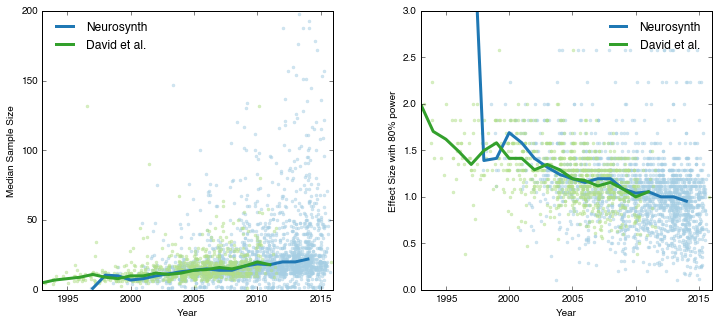

In [13]:
twocol = cb.qualitative.Paired_12.mpl_colors

fig,axs = plt.subplots(1,2,figsize=(12,5))
fig.subplots_adjust(hspace=.5,wspace=.3)
axs=axs.ravel()
axs[0].plot(Data.year_jitter[Data.source=="Tal"],Data.n[Data.source=="Tal"],"r.",color=twocol[0],alpha=0.5,label="")
axs[0].plot(Data.year_jitter[Data.source=="David"],Data.n[Data.source=="David"],"r.",color=twocol[2],alpha=0.5,label="")
axs[0].plot(Medians.year,Medians.TalMdSS,color=twocol[1],lw=3,label="Neurosynth")
axs[0].plot(Medians.year,Medians.DavidMdSS,color=twocol[3],lw=3,label="David et al.")
axs[0].set_xlim([1993,2016])
axs[0].set_ylim([0,200])
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Median Sample Size")
axs[0].legend(loc="upper left",frameon=False)

axs[1].plot(Data.year_jitter[Data.source=="Tal"],Data.deltaUnion[Data.source=="Tal"],"r.",color=twocol[0],alpha=0.5,label="")
axs[1].plot(Data.year_jitter[Data.source=="David"],Data.deltaUnion[Data.source=="David"],"r.",color=twocol[2],alpha=0.5,label="")
axs[1].plot(Medians.year,Medians.TalMdDUnion,color=twocol[1],lw=3,label="Neurosynth")
axs[1].plot(Medians.year,Medians.DavidMdDUnion,color=twocol[3],lw=3,label="David et al.")
axs[1].set_xlim([1993,2016])
axs[1].set_ylim([0,3])
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Effect Size with 80% power")
axs[1].legend(loc="upper right",frameon=False)
plt.show()

## The figure for different Alternatives

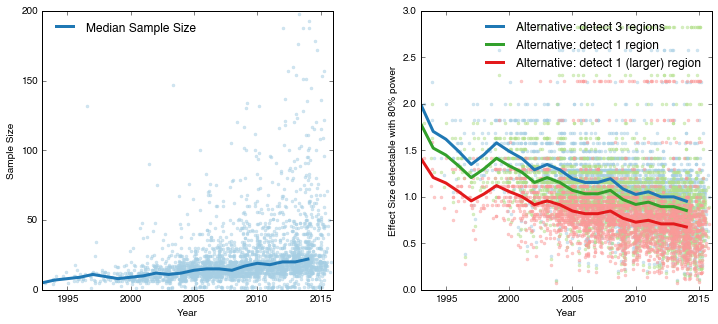

In [14]:
twocol = cb.qualitative.Paired_12.mpl_colors

fig,axs = plt.subplots(1,2,figsize=(12,5))
fig.subplots_adjust(hspace=.5,wspace=.3)
axs=axs.ravel()
axs[0].plot(Data.year_jitter,Data.n,"r.",color=twocol[0],alpha=0.5,label="")
axs[0].plot(Medians.year,Medians.MdSS,color=twocol[1],lw=3,label="Median Sample Size")
axs[0].set_xlim([1993,2016])
axs[0].set_ylim([0,200])
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Sample Size")
axs[0].legend(loc="upper left",frameon=False)

axs[1].plot(Data.year_jitter,Data.deltaUnion,"r.",color=twocol[0],alpha=0.5,label="")
axs[1].plot(Data.year_jitter,Data.deltaSingle,"r.",color=twocol[2],alpha=0.5,label="")
axs[1].plot(Data.year_jitter,Data.deltaLarge,"r.",color=twocol[4],alpha=0.5,label="")
axs[1].plot(Medians.year,Medians.DUnion,color=twocol[1],lw=3,label="Alternative: detect 3 regions")
axs[1].plot(Medians.year,Medians.DSingle,color=twocol[3],lw=3,label="Alternative: detect 1 region")
axs[1].plot(Medians.year,Medians.DLarge,color=twocol[5],lw=3,label="Alternative: detect 1 (larger) region")
axs[1].set_xlim([1993,2016])
axs[1].set_ylim([0,3])
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Effect Size detectable with 80% power")
axs[1].legend(loc="upper right",frameon=False)
plt.show()